In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import re
from glob import glob


import read_nml as rnl

from scipy.ndimage import uniform_filter
from scipy.ndimage import gaussian_filter
import matplotlib.colors as mcolors


from Utils import numerical_utils as nuti
from Utils import MyConstants as Co
from Utils import MakePressures as MkP

print( Co.cpair())

cpair = Co.cpair()
rdair = Co.Rdair()
grav= Co.grav()

 Utils.MyConstants in /glade/work/juliob/GW_UnitTest/Python/Utils 
1004.6480897776704


In [2]:
attr_list = []

def grab_attrs(ds):
    # store a copy of attrs from this file
    attr_list.append(dict(ds.attrs))
    return ds




def handle_wild( n ):
    if (n==99):
        n='*'
    elif (n is None):
        n='*'
    return n

In [3]:
#################
# set case name
#################

day,hour=None,None


#case='xympas-x00'
#case='xympas-Aug2016'
case='xympas-rdg-mm-front'
year,month,day,hour=2016,8, 99, 99


"""
case='xy-rdg-mm-front'
case='xy-Aug2004'
year,month,day,hour=2004,8, 99, 99
"""

day=handle_wild( day )
hour=handle_wild( hour )

if (hour != '*') and (day != '*' ):
    seconds=3_600 * hour
    f=f'/glade/derecho/scratch/juliob/archive/GW_UnitTest/{case}/{case}.h.{year:04}-{month:02}-{day:02}-{seconds:05}.nc'     #        camsnap-yaaaa.h.2004-06-15-21600.nc'
    title=f'{case}: {year:04}-{month:02}-{day:02}-{seconds:05}'     #        camsnap-yaaaa.h.2004-06-15-21600.nc'
elif (hour == '*') and (day != '*' ):
    f=f'/glade/derecho/scratch/juliob/archive/GW_UnitTest/{case}/{case}.h.{year:04}-{month:02}-{day:02}-*.nc'     #        camsnap-yaaaa.h.2004-06-15-21600.nc'
    title=f'{case}: {year:04}-{month:02}-{day:02}'     #        camsnap-yaaaa.h.2004-06-15-21600.nc'
elif (day=='*'):
    f=f'/glade/derecho/scratch/juliob/archive/GW_UnitTest/{case}/{case}.h.{year:04}-{month:02}-*.nc'     #        camsnap-yaaaa.h.2004-06-15-21600.nc'
    title=f'{case}: {year:04}-{month:02}'     #        camsnap-yaaaa.h.2004-06-15-21600.nc'


In [4]:
Xgw=xr.open_mfdataset( f,   preprocess=grab_attrs, data_vars='different', coords='different', compat='no_conflicts'  )
#Xgw=xr.open_mfdataset( f,   preprocess=grab_attrs, combine='by_coords' )


ncdata_list = [d["ncdata"] for d in attr_list]
X=xr.open_mfdataset( ncdata_list ,  data_vars='different', coords='different', compat='no_conflicts'  )



print(len(ncdata_list),ncdata_list[0],ncdata_list[-1])

ftopo='/glade/work/juliob/Topo/NCARTopoJTB/cases/fv1x1_Sco100_GrnlAnt/output/fv1x1_gmted2010_modis_bedmachine_nc3000_Laplace0100_noleak_greenlndantarcsgh30fac2.50_20251009.nc'
Topo=xr.open_dataset( ftopo )

247 /glade/derecho/scratch/juliob/archive/c124_dyamond1/atm/hist/DynVars_dyamond_fv1x1.2016-08-01-10800.nc /glade/derecho/scratch/juliob/archive/c124_dyamond1/atm/hist/DynVars_dyamond_fv1x1.2016-08-31-75600.nc


In [5]:
#read GW.dat file

%run -i val_camsnap_block.py


xympas-rdg-mm-front is not a snapshot calculation


In [6]:
%%time

ny = Xgw.sizes["ny"]
nx = Xgw.sizes["nx"]

j = np.arange(ny).repeat(nx)
i = np.tile(np.arange(nx), ny)

X2 = (
    Xgw.assign_coords(_j=("ncol", j), _i=("ncol", i))     # mapping ncol -> (j,i)
     .set_index(ncol=("_j", "_i"))
     .unstack("ncol")
     .rename({"_j": "ny", "_i": "nx"})
     .assign_coords(ny=Xgw["lat_R"], nx=Xgw["lon_R"])        # put real coords on axes
)


X2['lat']=Xgw['lat_R']
X2['lon']=Xgw['lon_R']
Xgw=X2

CPU times: user 3.85 s, sys: 451 ms, total: 4.3 s
Wall time: 7.31 s


In [7]:
%%time

tau_rdg=Xgw.TAU_RDG.values
tau_mmt=Xgw.TAU_MOVMTN.values
tau_diag_mmt=Xgw.TAU_DIAG_MOVMTN.values

if ('upwp' in X):
    upwp = X.upwp.values 
elif ('Upwp' in X):
    upwp = X.Upwp.values 

if ('vpwp' in X):
    vpwp = X.vpwp.values 
elif ('Vpwp' in X):
    vpwp = X.Vpwp.values 

#vpwp = X.vpwp.values


epwp = np.sqrt( upwp**2 + vpwp**2 )


print( np.max( tau_mmt) )
print( np.max( tau_diag_mmt) )



0.07335855
0.07335855
CPU times: user 11.2 s, sys: 22.5 s, total: 33.7 s
Wall time: 1min 47s


In [8]:

for t in np.arange(8):
    print( np.max( tau_mmt[t,23:25,:,:] ) )

0.052495606
0.048230033
0.049844
0.052808814
0.04549513
0.061687775
0.064101666
0.043949794


In [9]:
if (Xgw.calculation_type == 'xympas'):
    zlev=X.lev.values
    reso='3.75km'
else:
    zlev=-7_000.*np.log( X.lev.values /1_000.)
    reso='14km'

lat=X.lat.values
lon=X.lon.values

20160804.5
CPU times: user 4.43 s, sys: 8.3 s, total: 12.7 s
Wall time: 38.4 s


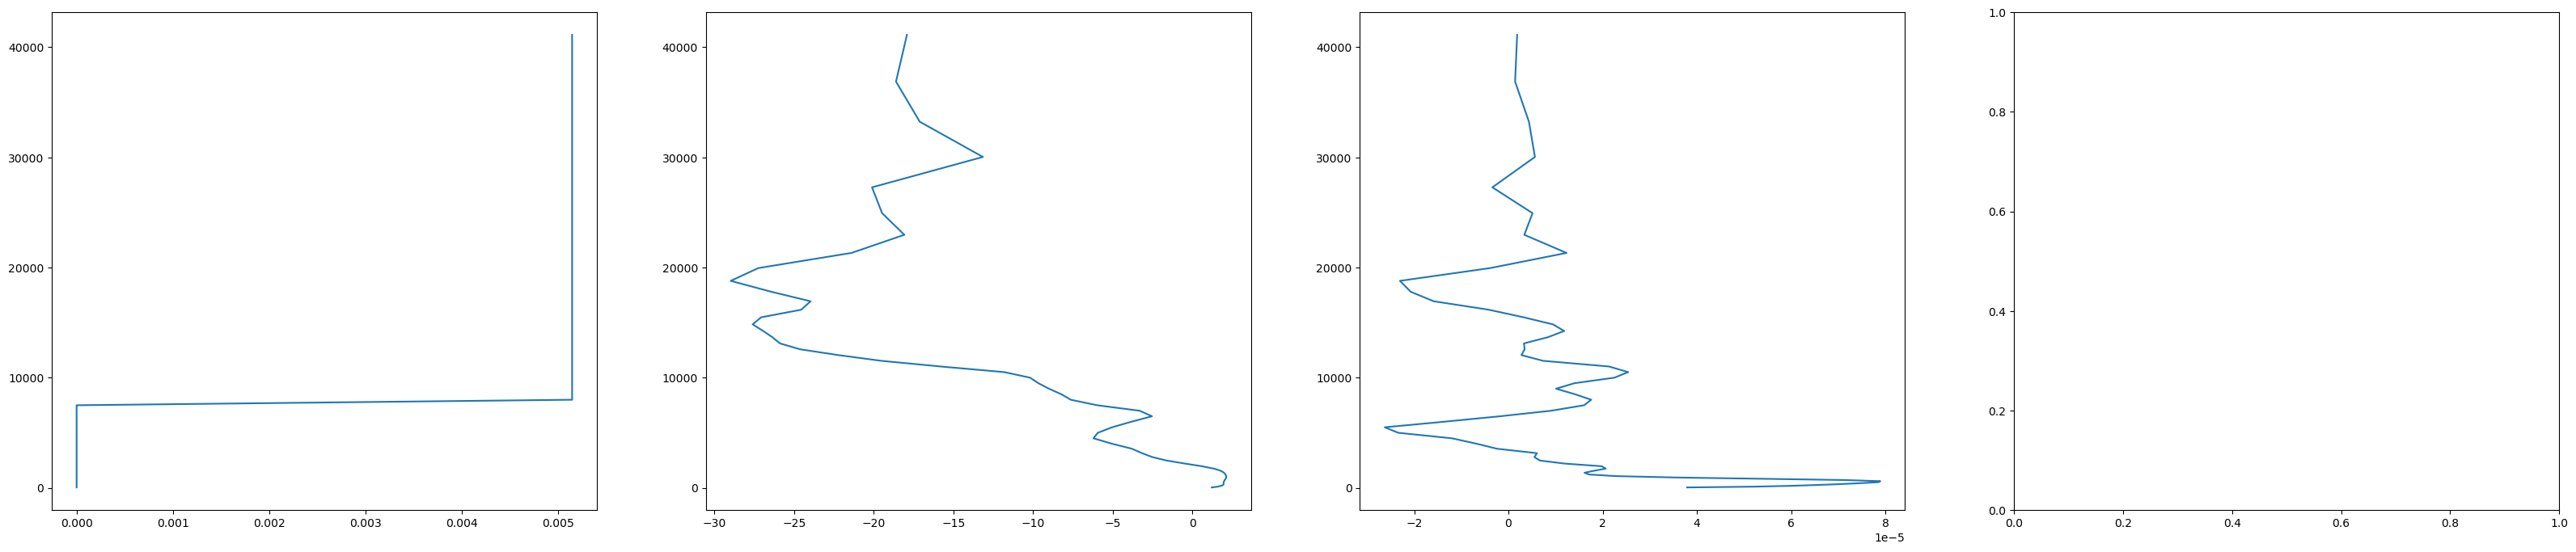

In [10]:
%%time

u=Xgw.U.values
zeta=Xgw.ZETA.values

nplo=4
t,z,y,x = 27,25,112,40
#t,z,y,x = 4,25,112,40

print( Xgw.time.values[t] )



fig,axs = plt.subplots( 1, nplo , figsize = (nplo*10,8) )

p=0
ax=axs[p]
ax.plot( tau_mmt[t,1:,y,x] , zlev )

p=1
ax=axs[p]
ax.plot( u[t,:,y,x] , zlev )

p=2
ax=axs[p]
ax.plot( zeta[t,:,y,x] , zlev )





In [11]:

print( Xgw.sizes )#[('ny','nx')])
nt,nz,ny,nx = Xgw.sizes['time'],  Xgw.sizes['level'],  Xgw.sizes['ny'],  Xgw.sizes['nx']

Frozen({'ny': 192, 'nx': 288, 'ilevel': 59, 'time': 247, 'level': 58})


In [12]:
## Rho scaling
if (Xgw.calculation_type == 'xympas'):
    pint=X.PINT.values
    pmid = 0.5*( pint[:,0:nz,:,:] + pint[:,1:nz+1,:,:] )
    te = X.T.values
    te_int = np.zeros( (nt,nz+1,ny,nx) )
    te_int[:,0,:]=te[:,0,:,:]
    te_int[:,nz,:]=te[:,nz-1,:,:]
    for z in np.arange( start=1,stop=nz ):
        te_int[:,z,:] = 0.5*( te[:,z-1,:] + te[:,z,:] )
    rho3d = pint / (rdair * te_int )
    rho_scl = rho3d
else:
    pmid,pint,delp =MkP.Pressure ( X=X , p_00=100_000., Gridkey='tzyx' )
    te = X.T.values
    RhoProxy = X.RhoProxy.values
    RhoProxy3D = np.broadcast_to(RhoProxy[None, :, None, None], (nt, nz, ny, nx))
    rho3d = pmid / (rdair * te )
    rho_scl = rho3d / RhoProxy3D

rho_epwp = rho_scl * epwp

In [13]:
%%time
#tau_rdg = tau_rdg.reshape((nt,nz+1,ny,nx) )
#tau_mmt = tau_mmt.reshape((nt,nz+1,ny,nx) )

tau_tot = tau_rdg + tau_mmt

CPU times: user 171 ms, sys: 271 ms, total: 442 ms
Wall time: 444 ms


In [14]:
tau_rdg_tv = np.average( tau_rdg, axis=0)
tau_mmt_tv = np.average( tau_mmt, axis=0)
tau_tot_tv = np.average( tau_tot, axis=0)

upwp_tv = np.average(upwp,axis=0)
epwp_tv = np.average(epwp,axis=0)
rho_epwp_tv = np.average(rho_epwp,axis=0)


htopo=Topo.PHIS.values/grav



In [15]:
%%time
print(nt,nz)

tau_tot_sm=np.zeros( (nt,nz+1,ny,nx) )
trunc_k, sigma=10, 4.5

for t in np.arange( nt ):
    for z in np.arange( nz ):
        tau_tot_sm[t,z,:,:] = gaussian_filter(  tau_tot[t,z,:,:] , sigma=sigma,
                                   truncate=((trunc_k-1)/2)/sigma, mode="nearest")
        
#tau_tot_smooth = uniform_filter(   tau_tot_tv[z,:,:]  , size=7, mode="wrap")   # 3x3

tau_tot_sm_tv = np.average( tau_tot_sm, axis=0 )

247 58
CPU times: user 5.7 s, sys: 508 ms, total: 6.2 s
Wall time: 6.68 s


[1.0e-05 2.0e-05 5.0e-05 1.0e-04 1.5e-04 2.0e-04 3.0e-04 4.0e-04 5.0e-04
 6.0e-04 8.0e-04 1.0e-03 1.5e-03 2.0e-03 3.0e-03 4.0e-03 5.0e-03 6.0e-03
 1.0e-02 2.0e-02 5.0e-02 1.0e-01]
19945.639649999997
19945.639649999997


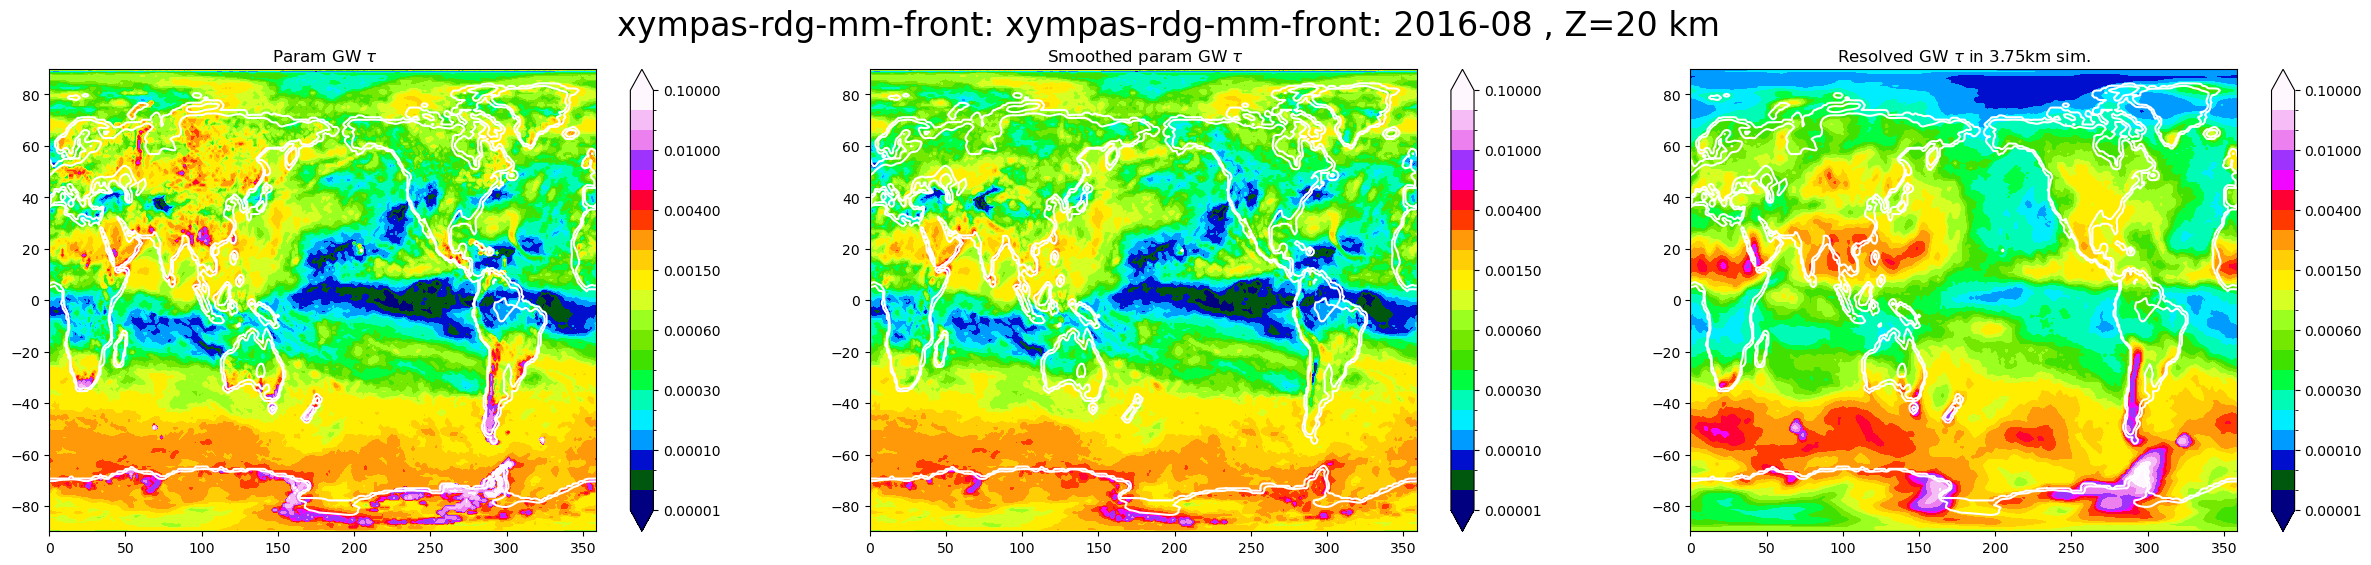

In [16]:
z=np.argmin( np.abs( zlev - 20_000. ) )

title_ = f'{case}: {title} , Z={zlev[z]/1000.:.0f} km '     #        camsnap-yaaaa.h.2004-06-15-21600.nc'


#flev=[0.0001,0.0002,0.0005,  0.001,0.002,0.005,  0.01,0.02,0.05,  0.1,0.2,0.5,   1.0  ]
flev=[0.0001,0.0002,0.0005,  0.001,0.0015,0.002,0.003,0.004,0.005,0.006,0.008,    0.01,0.015,0.02,0.03,0.04,0.05,0.06,  0.1,0.2,0.5,   1.0  ]
flev=0.1*np.asarray( flev )
print(flev)
cmapN='gist_ncar'

cmap = plt.cm.bwr  #gist_ncar  # Or any other colormap
cmap = plt.cm.gist_ncar # .plasma #gist_ncar  #gist_ncar  # Or any other colormap
norm = mcolors.BoundaryNorm(boundaries=flev, ncolors=cmap.N, clip=False)

topocolor='white' #'black'


fig,axs=plt.subplots( 1, 3, figsize=(30,6) )
ax=axs[0]
c = ax.contourf( lon, lat, tau_tot_tv[z,:,:],levels=flev, cmap=cmap , norm=norm, extend='both'  )
to = ax.contour( lon, lat, htopo, levels=[1,100] ,colors=topocolor)
ax.set_title( " Param GW "+ r"$\tau$")
plt.colorbar( c )

ax=axs[1]
#c = ax.contourf( lon, lat, tau_tot_sm_tv[z,:,:],levels=flev, cmap=cmap , norm=norm, extend='both'  )
c = ax.contourf( lon, lat, np.mean( tau_mmt[:,z,:,:], axis=0) ,levels=flev, cmap=cmap , norm=norm, extend='both'  )
to = ax.contour( lon, lat, htopo, levels=[1,100] ,colors=topocolor)
ax.set_title( " Smoothed param GW "+ r"$\tau$")
plt.colorbar( c )


ax=axs[2]
c = ax.contourf( lon, lat, rho_epwp_tv[z,:,:] ,levels=flev, cmap=cmap , norm=norm, extend='both'  )
to = ax.contour( lon, lat, htopo, levels=[1,100] ,colors=topocolor)
ax.set_title( f'Resolved GW {r"$\tau$"} in {reso} sim.')
plt.colorbar( c )

plt.suptitle( title_ , fontsize=24) 

print(X.lev[z].values)
print(zlev[z])


[1.0e-05 2.0e-05 5.0e-05 1.0e-04 1.5e-04 2.0e-04 3.0e-04 4.0e-04 5.0e-04
 6.0e-04 8.0e-04 1.0e-03 1.5e-03 2.0e-03 3.0e-03 4.0e-03 5.0e-03 6.0e-03
 1.0e-02 2.0e-02 5.0e-02 1.0e-01]
24932.2041
24932.2041


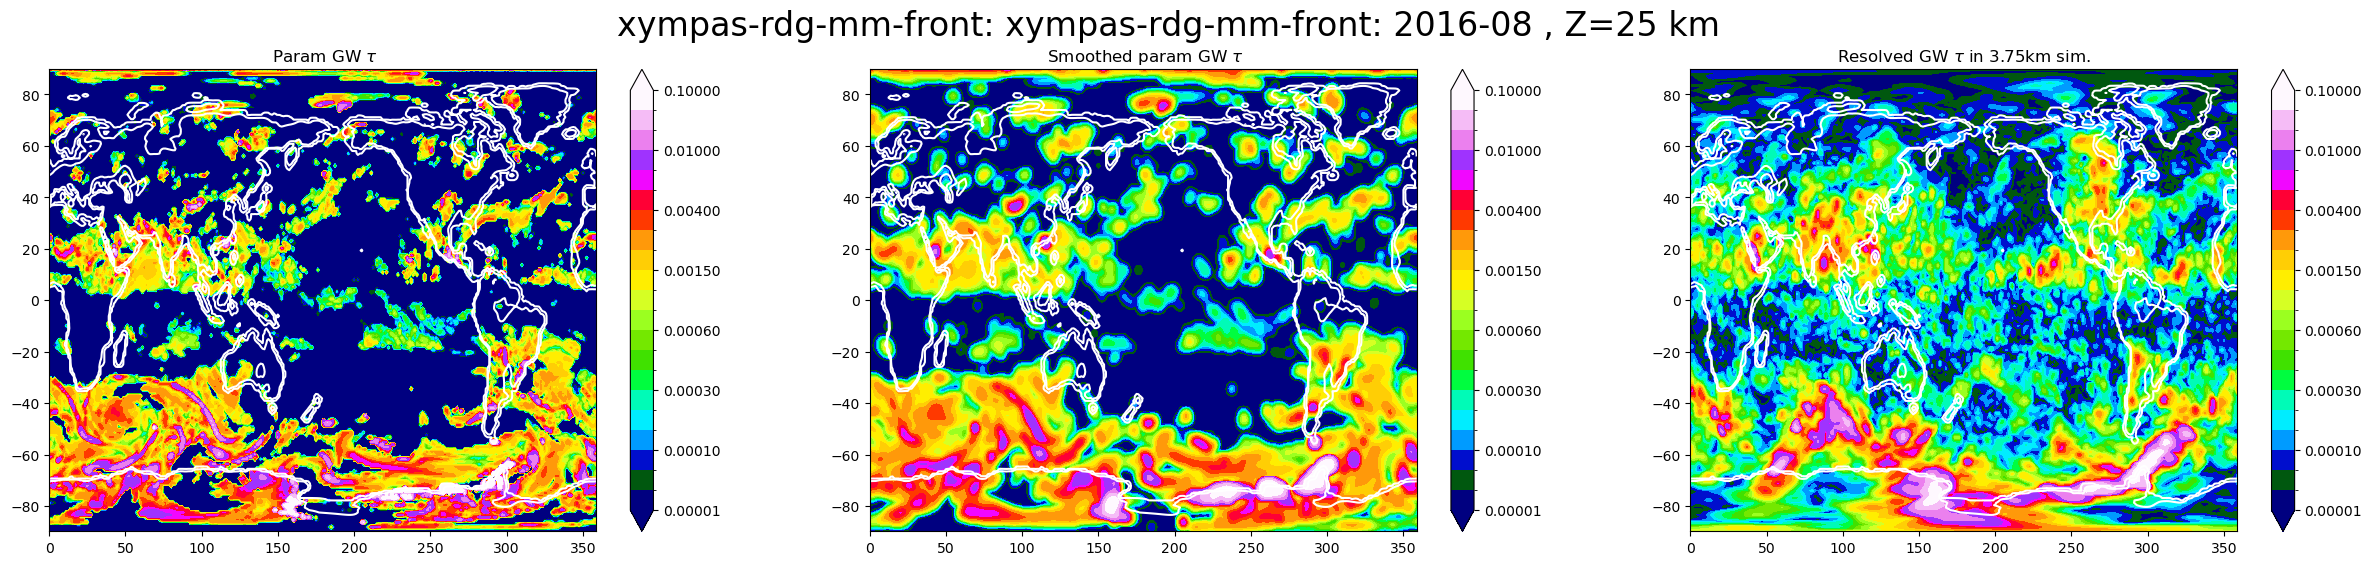

In [17]:
z=np.argmin( np.abs( zlev - 25_000. ) )
t=3

title_ = f'{case}: {title} , Z={zlev[z]/1000.:.0f} km '     #        camsnap-yaaaa.h.2004-06-15-21600.nc'

tau_tot_smooth = uniform_filter(   tau_tot_tv[z,:,:]  , size=7, mode="wrap")   # 3x3

trunc_k, sigma=7, 1.5
tau_tot_smooth = gaussian_filter(  tau_tot[t,z,:,:] , sigma=sigma,
                           truncate=((trunc_k-1)/2)/sigma, mode="nearest")


#flev=[0.0001,0.0002,0.0005,  0.001,0.002,0.005,  0.01,0.02,0.05,  0.1,0.2,0.5,   1.0  ]
flev=[0.0001,0.0002,0.0005,  0.001,0.0015,0.002,0.003,0.004,0.005,0.006,0.008,    0.01,0.015,0.02,0.03,0.04,0.05,0.06,  0.1,0.2,0.5,   1.0  ]
flev=0.1*np.asarray( flev )
print(flev)
cmapN='gist_ncar'

cmap = plt.cm.bwr  #gist_ncar  # Or any other colormap
cmap = plt.cm.gist_ncar # .plasma #gist_ncar  #gist_ncar  # Or any other colormap
norm = mcolors.BoundaryNorm(boundaries=flev, ncolors=cmap.N, clip=False)

topocolor='white' #'black'


fig,axs=plt.subplots( 1, 3, figsize=(30,6) )



ax=axs[0]
c = ax.contourf( lon, lat, tau_tot[t,z,:,:],levels=flev, cmap=cmap , norm=norm, extend='both'  )
to = ax.contour( lon, lat, htopo, levels=[1,100] ,colors=topocolor)
ax.set_title( " Param GW "+ r"$\tau$")
plt.colorbar( c )

ax=axs[1]
c = ax.contourf( lon, lat, tau_tot_smooth,levels=flev, cmap=cmap , norm=norm, extend='both'  )
to = ax.contour( lon, lat, htopo, levels=[1,100] ,colors=topocolor)
ax.set_title( " Smoothed param GW "+ r"$\tau$")
plt.colorbar( c )


ax=axs[2]
c = ax.contourf( lon, lat, rho_epwp[t,z,:,:] ,levels=flev, cmap=cmap , norm=norm, extend='both'  )
to = ax.contour( lon, lat, htopo, levels=[1,100] ,colors=topocolor)
ax.set_title( f'Resolved GW {r"$\tau$"} in {reso} sim.')
plt.colorbar( c )

plt.suptitle( title_ , fontsize=24)

print(X.lev[z].values)
print(zlev[z])


In [18]:
z0,lat0,lon0 = 25_000., -45.,10.
z,y,x = np.argmin( np.abs( zlev - z0 ) ),np.argmin( np.abs( lat-lat0 ) ),np.argmin( np.abs( lon - lon0 ) )
print( z,y,x)


5 48 8


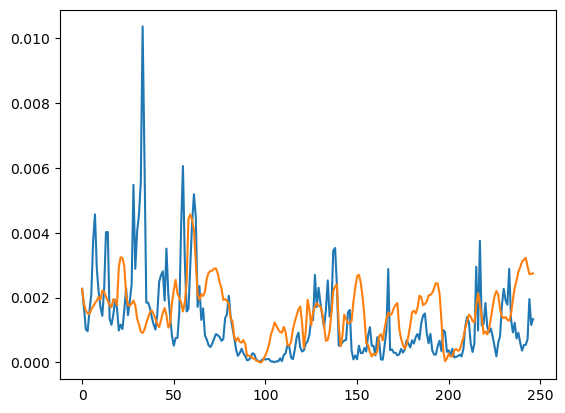

In [19]:
plt.plot( rho_epwp[:,z,y,x] )
plt.plot( tau_tot_sm[:,z,y,x] )


In [20]:

%%time
coco=np.zeros( (nz,ny,nx) )
print( nz,ny,nx)
print( rho_epwp.shape)
print( tau_tot_sm.shape)
for z in np.arange( nz ):
    for y in np.arange( ny ):
        for x in np.arange( nx ):
            cox=rho_epwp[:,z,y,x]
            coy=tau_tot_sm[:,z,y,x]
            mask = np.isfinite(cox) & np.isfinite(coy)
            coco[z,y,x] = np.corrcoef(cox[mask], coy[mask])[0,1]



58 192 288
(247, 59, 192, 288)
(247, 59, 192, 288)


/glade/u/apps/opt/miniforge/envs/npl-2026a/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/glade/u/apps/opt/miniforge/envs/npl-2026a/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


CPU times: user 1min 53s, sys: 16 ms, total: 1min 53s
Wall time: 2min 4s


In [21]:
z0,lat0,lon0 = 20_000., -50.,50.
z,y,x = np.argmin( np.abs( zlev - z0 ) ),np.argmin( np.abs( lat-lat0 ) ),np.argmin( np.abs( lon - lon0 ) )


#plt.contourf(lon,lat,coco[z,:,:] )
#plt.colorbar()

In [22]:
tau_mmt.shape

(247, 59, 192, 288)

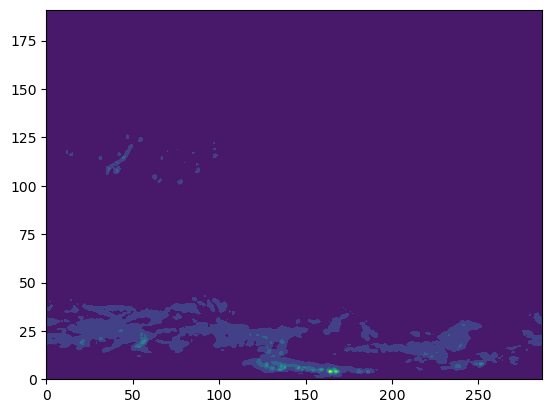

In [23]:
plt.contourf( np.average( tau_mmt, axis=0)[z,:,:] )

0.07335855


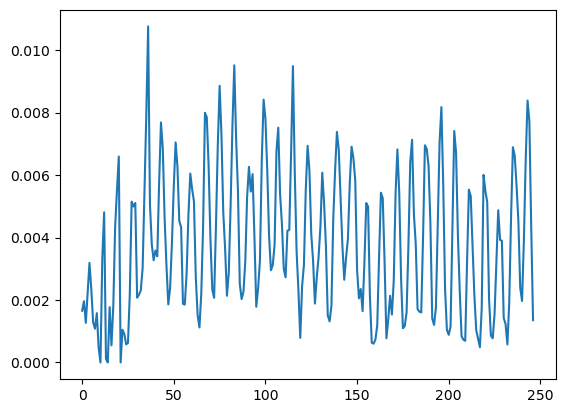

In [24]:
plt.plot( tau_mmt[:,25,112,40] )
#plt.plot( tau_mmt[:,25,20,40] )
print( np.max( tau_mmt ) )
#plt.xlim(20,30)

In [25]:
tausrc_mm = Xgw.TAU_SRC_MOVMVTN.values
print( list(Xgw.variables ))

['lat_R', 'lon_R', 'ilev', 'zgrid', 'lat', 'lon', 'SGH', 'PS', 'ZM', 'ZI', 'PMID', 'PINT', 'U', 'V', 'T', 'TH', 'FRONTGF', 'FRONTGA', 'TAU_A_RDG', 'TAU_B_RDG', 'BWV', 'TLB', 'WBR', 'UBMSRC_RDG', 'NSRC_RDG', 'TAUORO', 'UBM_RDG', 'TAUDSW', 'TAU_RDG', 'TAU_DIAG_RDG', 'UTRDG', 'VTRDG', 'TAU_SRC_MOVMVTN', 'UBM', 'ZETA', 'TAU_MOVMTN', 'TAU_DIAG_MOVMTN', 'TAUE_MM', 'TAUW_MM', 'TAUN_MM', 'TAUS_MM', 'TAUE', 'TAUW', 'TAUN', 'TAUS', 'time', 'ny', 'nx']


In [26]:
#plt.plot( tau_mmt[:,25,112,40]
tausrc_mm.shape


(247, 59, 192, 288)

24932.2041


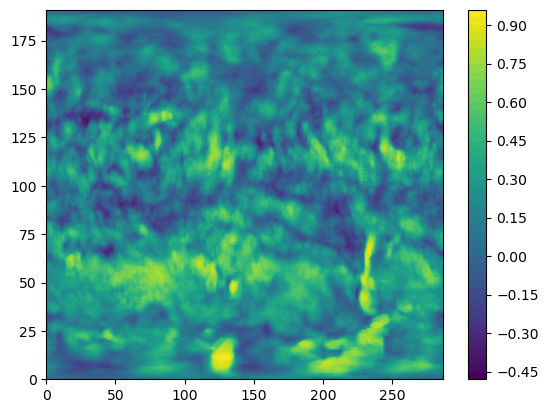

In [27]:
z=5
print( zlev[z] )
plt.contourf ( coco[z,:,: ], levels=51 )
#plt.xlim( 220,250)
#plt.ylim(30,50)
plt.colorbar()

In [28]:
z,y,x= 20,43,229
cox=rho_epwp[:,z,y,x]
coy=tau_tot_sm[:,z,y,x]


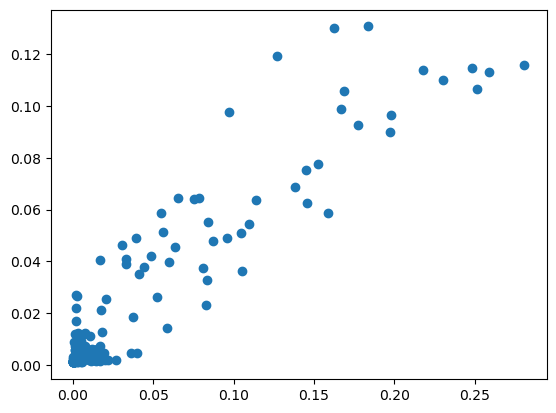

In [29]:
plt.scatter(cox,coy)

24932.2041 -40.99476439790574
(288,)
(247,)
(247, 59, 192, 288)


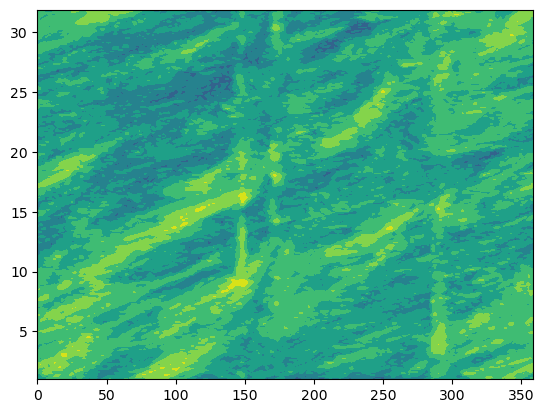

In [60]:
z0=25_000.
lat0 =-41. 
z,y =  np.argmin( np.abs( zlev - z0 ) ) , np.argmin( np.abs( lat - lat0 ) )
print( zlev[z], lat[y] )

time=1+np.linspace ( 0,nt , num=nt) /8.
rho_epwp[:,z,y,x]

print ( lon.shape )
print ( time.shape )
print ( rho_epwp.shape )

plt.contourf( lon, time, np.log(rho_epwp[:,z,y,:]) )



In [ ]:
plt.contourf( 

1064.2665714999998


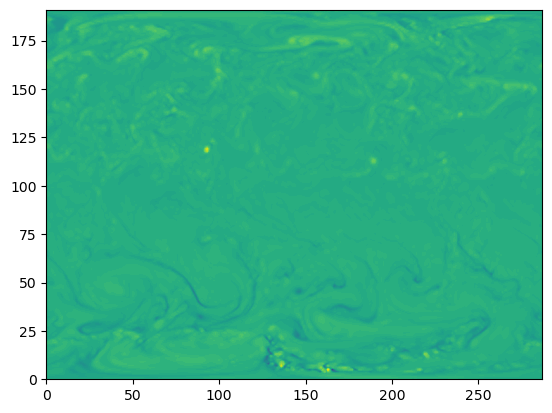

In [30]:
z=46
print( zlev[z] )
plt.contourf ( zeta[t,z,:,: ], levels=51 )

In [31]:
enstro=zeta**2

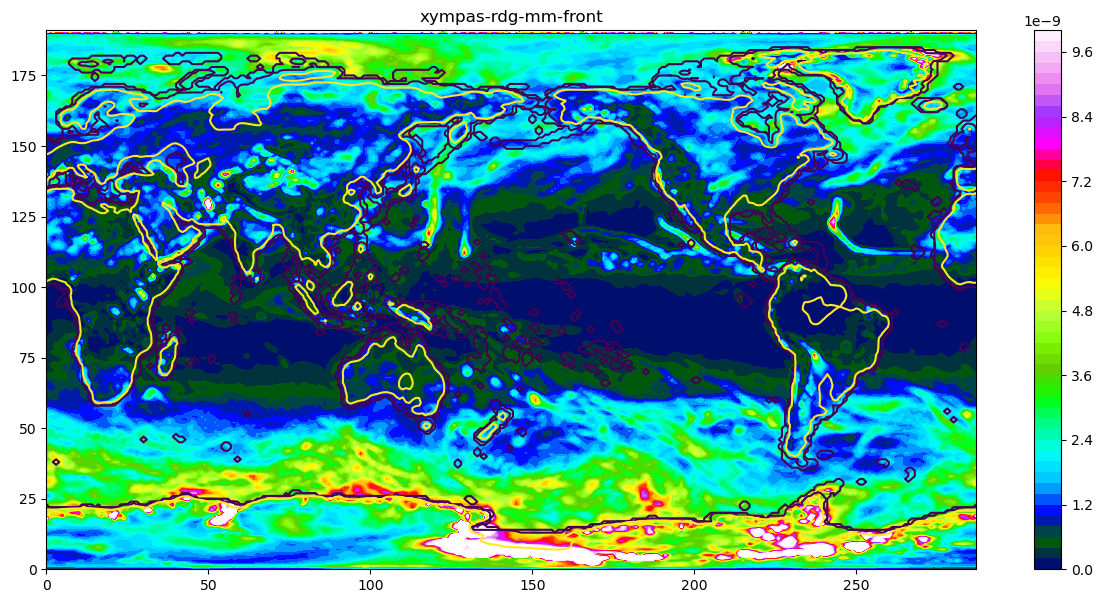

In [32]:
slev=1.e-8 * np.linspace( 0.,1.,num=51 )
cmap='gist_ncar'

fig,ax=plt.subplots( figsize=(15,7) )
c = ax.contourf( np.mean( np.mean( enstro[:,46:,:,:], axis=0 ), axis=0) ,levels=slev , cmap=cmap )
t=ax.contour( htopo, levels=[0,1,100] )
ax.set_title( case )
plt.colorbar(c)

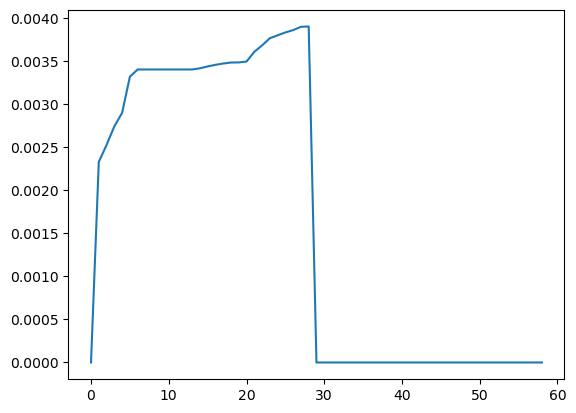

In [33]:
plt.plot( np.average( tau_mmt, axis=0)[:,112,40] )

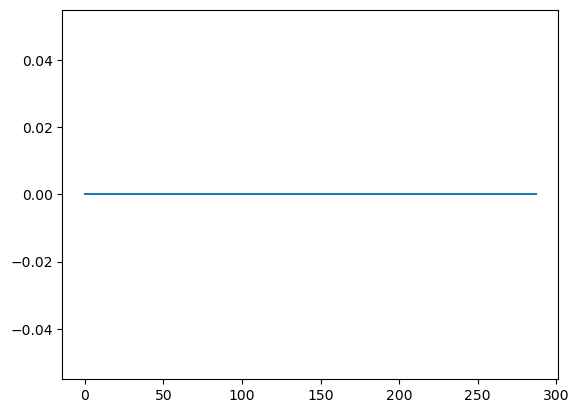

In [34]:
plt.plot( np.average( tau_mmt, axis=0)[z,112,:] )

In [35]:
Xgw


<xarray.Dataset> Size: 100GB
Dimensions:          (ny: 192, nx: 288, ilevel: 59, time: 247, level: 58)
Coordinates:
  * ny               (ny) float64 2kB -89.76 -89.06 -88.12 ... 88.12 89.06 89.76
  * nx               (nx) float64 2kB 0.0 1.25 2.5 3.75 ... 356.2 357.5 358.8
  * time             (time) float64 2kB 2.016e+07 2.016e+07 ... 2.016e+07
Dimensions without coordinates: ilevel, level
Data variables: (12/45)
    lat_R            (ny) float64 2kB dask.array<chunksize=(192,), meta=np.ndarray>
    lon_R            (nx) float64 2kB dask.array<chunksize=(288,), meta=np.ndarray>
    ilev             (ilevel) float32 236B dask.array<chunksize=(59,), meta=np.ndarray>
    zgrid            (time, ilevel, ny, nx) float32 3GB dask.array<chunksize=(1, 59, 192, 288), meta=np.ndarray>
    lat              (ny) float64 2kB dask.array<chunksize=(192,), meta=np.ndarray>
    lon              (nx) float64 2kB dask.array<chunksize=(288,), meta=np.ndarray>
    ...               ...
    TAUN_MM          (time, ilevel, ny, nx) float32 3GB dask.array<chunksize=(1, 59, 192, 288), meta=np.ndarray>
    TAUS_MM          (time, ilevel, ny, nx) float32 3GB dask.array<chunksize=(1, 59, 192, 288), meta=np.ndarray>
    TAUE             (time, ilevel, ny, nx) float32 3GB dask.array<chunksize=(1, 59, 192, 288), meta=np.ndarray>
    TAUW             (time, ilevel, ny, nx) float32 3GB dask.array<chunksize=(1, 59, 192, 288), meta=np.ndarray>
    TAUN             (time, ilevel, ny, nx) float32 3GB dask.array<chunksize=(1, 59, 192, 288), meta=np.ndarray>
    TAUS             (time, ilevel, ny, nx) float32 3GB dask.array<chunksize=(1, 59, 192, 288), meta=np.ndarray>
Attributes:
    ncdata:            /glade/derecho/scratch/juliob/archive/c124_dyamond1/at...
    calculation_type:  xympas
    Conventions:       CF-1.8

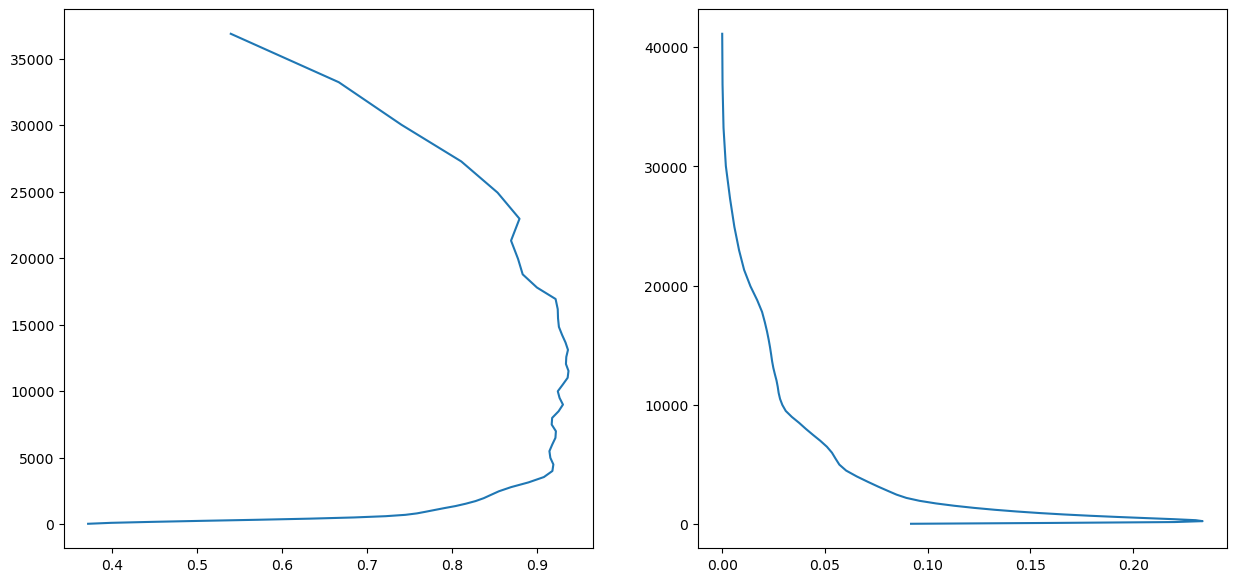

In [36]:
fig,axs=plt.subplots( 1,2, figsize=(15,7))
p=0
ax=axs[p]
ax.plot(coco[:,y,x],zlev )

p=1
ax=axs[p]
ax.plot(rho_epwp_tv[1:,y,x],zlev )



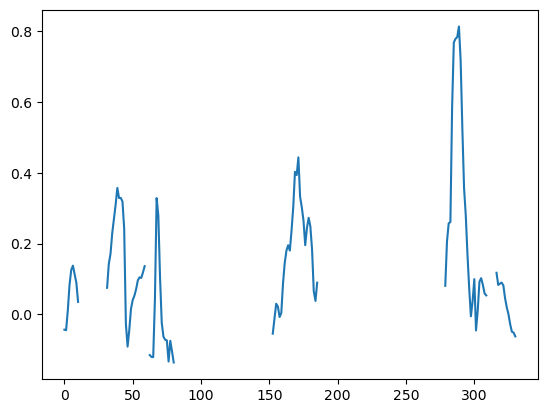

In [37]:
plt.plot(lon,coco[z,y,:] )

1064.2665714999998


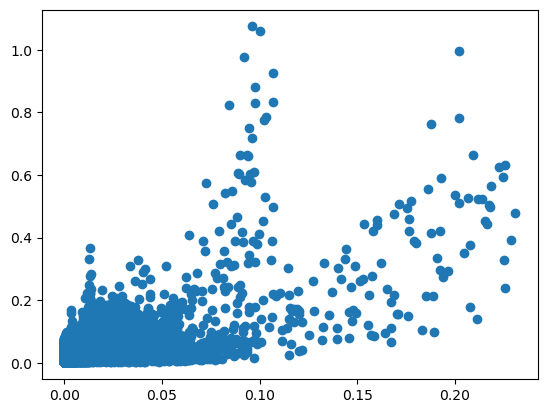

In [38]:
plt.scatter( tau_tot_sm_tv[z,:,:], epwp_tv[z,:,:] )
#plt.scatter( tau_tot_tv[z,:,:] , epwp_tv[z,:,:] )
print( zlev[z] )

In [39]:
Xgw

<xarray.Dataset> Size: 100GB
Dimensions:          (ny: 192, nx: 288, ilevel: 59, time: 247, level: 58)
Coordinates:
  * ny               (ny) float64 2kB -89.76 -89.06 -88.12 ... 88.12 89.06 89.76
  * nx               (nx) float64 2kB 0.0 1.25 2.5 3.75 ... 356.2 357.5 358.8
  * time             (time) float64 2kB 2.016e+07 2.016e+07 ... 2.016e+07
Dimensions without coordinates: ilevel, level
Data variables: (12/45)
    lat_R            (ny) float64 2kB dask.array<chunksize=(192,), meta=np.ndarray>
    lon_R            (nx) float64 2kB dask.array<chunksize=(288,), meta=np.ndarray>
    ilev             (ilevel) float32 236B dask.array<chunksize=(59,), meta=np.ndarray>
    zgrid            (time, ilevel, ny, nx) float32 3GB dask.array<chunksize=(1, 59, 192, 288), meta=np.ndarray>
    lat              (ny) float64 2kB dask.array<chunksize=(192,), meta=np.ndarray>
    lon              (nx) float64 2kB dask.array<chunksize=(288,), meta=np.ndarray>
    ...               ...
    TAUN_MM          (time, ilevel, ny, nx) float32 3GB dask.array<chunksize=(1, 59, 192, 288), meta=np.ndarray>
    TAUS_MM          (time, ilevel, ny, nx) float32 3GB dask.array<chunksize=(1, 59, 192, 288), meta=np.ndarray>
    TAUE             (time, ilevel, ny, nx) float32 3GB dask.array<chunksize=(1, 59, 192, 288), meta=np.ndarray>
    TAUW             (time, ilevel, ny, nx) float32 3GB dask.array<chunksize=(1, 59, 192, 288), meta=np.ndarray>
    TAUN             (time, ilevel, ny, nx) float32 3GB dask.array<chunksize=(1, 59, 192, 288), meta=np.ndarray>
    TAUS             (time, ilevel, ny, nx) float32 3GB dask.array<chunksize=(1, 59, 192, 288), meta=np.ndarray>
Attributes:
    ncdata:            /glade/derecho/scratch/juliob/archive/c124_dyamond1/at...
    calculation_type:  xympas
    Conventions:       CF-1.8

In [40]:
print(zlev[z])
print(X.lev[z].values)

1064.2665714999998
1064.2665714999998


In [41]:
plt.plot( axv[:,30:50,0:100].flatten() )

NameError: name 'axv' is not defined